# Reverse engineering ngmix' gaussian moments

In [1]:
%pylab inline

Populating the interactive namespace from numpy and matplotlib


In [2]:
import ngmix
import autometacal
import tensorflow as tf

Get a galaxy:

In [3]:
scale = .2
stamp_size=51
gal, psf = autometacal.data.galaxies.make_data(img_noise=0.0005,gal_g1=[0.],gal_g2=[0.5],scale=scale)

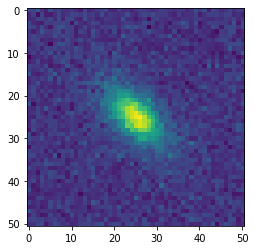

In [4]:
imshow(gal.numpy()[0])
obs=ngmix.Observation(gal.numpy()[0],jacobian=ngmix.DiagonalJacobian(
        row=25, col=25, scale=.2,
    )
)

Set a fitter with Gaussian moments:

In [5]:
weight_fwhm = scale*stamp_size/2 # <- this sets everything for the window function
fitter = ngmix.gaussmom.GaussMom(fwhm=weight_fwhm)

calculate moments:

In [6]:
fitter._measure_moments(obs)

{'flags': 0,
 'npix': 2601,
 'wsum': 28.391886409860447,
 'sums': array([-0.00014082, -0.00075055,  0.00196324,  0.0283736 ,  0.05426553,
         0.03195314]),
 'sums_cov': array([[ 1.36575550e+00, -1.54954090e-18, -1.90131368e-16,
         -2.00238589e-17, -1.15060956e-17, -7.90294975e-18],
        [-2.41076165e-18,  1.36575550e+00, -2.89693738e-17,
         -5.68748743e-17, -8.08188016e-17, -1.94671994e-18],
        [-1.89264642e-16,  1.43853723e-17,  1.21351863e+01,
          2.98011602e-17,  4.72483448e-17,  2.22713847e-15],
        [-6.14268293e-18, -5.75253956e-17,  2.29164764e-17,
          1.26799874e+01, -3.73507648e-17, -3.52111596e-18],
        [-9.28348110e-18, -6.00800469e-17,  9.92976724e-17,
         -6.49979202e-17,  2.48151738e+01,  2.73151100e+00],
        [-7.90294975e-18, -1.94671994e-18,  2.22713847e-15,
         -3.52111596e-18,  2.73151100e+00,  5.88419538e-01]]),
 'pars': array([-0.00440716, -0.02348914,  0.06144117,  0.88797558,  1.69828491,
         0.7988284

## How it works?

ngmix dtypes:

In [7]:
_gauss2d_dtype = [
  ("p", "f8"),
  ("row", "f8"),
  ("col", "f8"),
  ("irr", "f8"),
  ("irc", "f8"),
  ("icc", "f8"),
  ("det", "f8"),
  ("norm_set", "i8"),
  ("drr", "f8"),
  ("drc", "f8"),
  ("dcc", "f8"),
  ("norm", "f8"),
  ("pnorm", "f8"),
]

_moments_result_dtype = [
  ('flags', 'i4'),
  ('npix', 'i4'),
  ('wsum', 'f8'),
  ('sums', 'f8', 6),
  ('sums_cov', 'f8', (6, 6)),
  ('pars', 'f8', 6),
  ('F', 'f8', 6),
]

_pixels_dtype = [
  ("u", "f8"),
  ("v", "f8"),
  ("area", "f8"),
  ("val", "f8"),
  ("ierr", "f8"),
  ("fdiff", "f8"),
]


In [82]:
T = ngmix.moments.fwhm_to_T(weight_fwhm)

# the weight is always centered at 0, 0 or the
# center of the coordinate system as defined
# by the jacobian

weight = ngmix.GMixModel(
    [0.0, 0.0, 0.0, 0.0, T, 1.0],
    'gauss',
)

# make the max of the weight 1.0 to get better
# fluxes

weight.set_norms()
norm = weight.get_data()['norm'][0]
weight.set_flux(1.0/norm)
print(weight._data)
weight.set_norms()
print(weight._data)

[(29.47167182, 0., 0., 4.69056225, 0., 4.69056225, 22.00137424, 0, 0.21319406, 0., 0.21319406, 0.03393089, 0.03393089)]
[(29.47167182, 0., 0., 4.69056225, 0., 4.69056225, 22.00137424, 1, 0.21319406, 0., 0.21319406, 0.03393089, 1.)]


In [11]:
import tensorflow as tf
def g1g2_to_e1e2(g1, g2):
    """
    convert g to e
    """

    g = tf.math.sqrt(g1 * g1 + g2 * g2)


    if g == 0.0:
        e1 = 0.0
        e2 = 0.0
    else:

        eta = 2 * tf.math.atanh(g)
        e = tf.math.tanh(eta)
        if e >= 1.0:
            e = 0.99999999

        fac = e / g

        e1 = fac * g1
        e2 = fac * g2

    return e1, e2 #remove numpy later

In [86]:
_pvals_exp = array(
    [
        0.00061601229677880041,
        0.0079461395724623237,
        0.053280454055540001,
        0.21797364640726541,
        0.45496740582554868,
        0.26521634184240478,
    ]
)

_fvals_exp = array(
    [
        0.002467115141477932,
        0.018147435573256168,
        0.07944063151366336,
        0.27137669897479122,
        0.79782256866993773,
        2.1623306025075739,
    ]
)

_pvals_gauss = array([1.0])
_fvals_gauss = array([1.0])

def gauss2d_set(gauss,p, row, col, irr, irc, icc):
    """
    set the gaussian, clearing normalizations
    """
    
    gauss["norm_set"] = 0
    gauss["drr"] = nan
    gauss["drc"] = nan
    gauss["dcc"] = nan
    gauss["norm"] = nan
    gauss["pnorm"] = nan

    gauss["p"] = p
    gauss["row"] = row
    gauss["col"] = col
    gauss["irr"] = irr
    gauss["irc"] = irc
    gauss["icc"] = icc

    gauss["det"] = irr * icc - irc * irc

def gmix_fill_simple(gmix, pars, fvals, pvals):
    """
    fill a simple (6 parameter) gaussian mixture model
    no error checking done here
    """

    row = pars[0]
    col = pars[1]
    g1 = pars[2]
    g2 = pars[3]
    T = pars[4]
    flux = pars[5]

    e1, e2 = g1g2_to_e1e2(g1, g2)

    n_gauss = gmix.size
    for i in range(n_gauss):

        gauss = gmix[i]

        T_i_2 = 0.5 * T * fvals[i]
        flux_i = flux * pvals[i]

        gauss2d_set(
            gauss,
            flux_i,
            row,
            col,
            T_i_2 * (1 - e1),
            T_i_2 * e2,
            T_i_2 * (1 + e1),
        )

def gauss2d_set_norm(gauss):
    """
    set the normalization, and normalized variances

    parameters
    ----------
    gauss: a 2-d gaussian structure
        See gmix.py
    """

    T = gauss["irr"] + gauss["icc"]
    idet = 1.0 / gauss["det"]

    gauss["drr"] = gauss["irr"] * idet
    gauss["drc"] = gauss["irc"] * idet
    gauss["dcc"] = gauss["icc"] * idet
    gauss["norm"] = 1.0 / (2 * numpy.pi * numpy.sqrt(gauss["det"]))
    gauss["pnorm"] = gauss["p"] * gauss["norm"]
    gauss["norm_set"] = 1
        
def create_empty_gmix(n_gauss):
  empty_gmix = []
    
  for gau in range(n_gauss):
    dt = np.dtype(_gauss2d_dtype)
    gaussarray = np.zeros(1, dtype=dt)
    empty_gmix.append(gaussarray)
  
  return np.array(empty_gmix)    


def gmix_set_norms(gmix):
    """
    set all norms for gaussians in the input gaussian mixture
    parameters
    ----------
    gmix:
       gaussian mixture
    """
    for gauss in gmix:
        gauss2d_set_norm(gauss)
        
def gmix_set_flux(gmix, psum):
    """
    set a new value for sum(p)
    """


    psum0 = sum([gauss["p"] for gauss in gmix])
    rat = psum / psum0
    gmix["p"] *= rat

    # we will need to reset the pnorm values
    gmix["norm_set"] = 0

def create_gmix(pars,model):
  
  if model == 'gauss':
    n_gauss = 1
    fvals =  _fvals_gauss
    pvals = _pvals_gauss
  
  if model == 'exp': #this is not working yet, pnorms are not properly set?
    n_gauss = 6
    fvals = _fvals_exp
    pvals = _pvals_exp
  
  gmix = create_empty_gmix(n_gauss)
  gmix_fill_simple(gmix,pars,fvals,pvals)
  gmix_set_norms(gmix)
  gmix_set_flux(gmix,1./gmix['norm'])
  gmix_set_norms(gmix)

   
  return gmix
   
  

In [63]:
gaussian[0]["pnorm"] =1

In [84]:
T = ngmix.moments.fwhm_to_T(weight_fwhm)

# the weight is always centered at 0, 0 or the
# center of the coordinate system as defined
# by the jacobian

weight = ngmix.GMixModel(
    [0.0, 0.0, 0.0, 0.0, T, 1.0],
    'gauss',
)

# make the max of the weight 1.0 to get better
# fluxes

weight.set_norms()
norm = weight.get_data()['norm'][0]
weight.set_flux(1.0/norm)
weight.set_norms()
list(weight._data)

[(29.47167182, 0., 0., 4.69056225, 0., 4.69056225, 22.00137424, 1, 0.21319406, 0., 0.21319406, 0.03393089, 1.)]

In [85]:
dict(zip(fitter.weight._data.dtype.names,fitter.weight._data[0]))

{'p': 29.471671822231333,
 'row': 0.0,
 'col': 0.0,
 'irr': 4.690562251690243,
 'irc': 0.0,
 'icc': 4.690562251690243,
 'det': 22.00137423698144,
 'norm_set': 1,
 'drr': 0.2131940578423515,
 'drc': 0.0,
 'dcc': 0.2131940578423515,
 'norm': 0.03393088814342969,
 'pnorm': 1.0}

In [87]:
T = ngmix.moments.fwhm_to_T(weight_fwhm)
gaussian = create_gmix([0.,0.,0.,0.,T,1.],'gauss')
gaussian

array([[(29.47167182, 0., 0., 4.69056225, 0., 4.69056225, 22.00137424, 1, 0.21319406, 0., 0.21319406, 0.03393089, 1.)]],
      dtype=[('p', '<f8'), ('row', '<f8'), ('col', '<f8'), ('irr', '<f8'), ('irc', '<f8'), ('icc', '<f8'), ('det', '<f8'), ('norm_set', '<i8'), ('drr', '<f8'), ('drc', '<f8'), ('dcc', '<f8'), ('norm', '<f8'), ('pnorm', '<f8')])

In [88]:
def gauss2d_eval_pixel(gauss, pixel):
    """
    evaluate a 2-d gaussian at the specified location
    parameters
    ----------
    gauss2d: gauss2d structure
        row,col,dcc,drr,drc,pnorm... See gmix.py
    pixel: struct with coods
        should have fields v,u
    """
    model_val = 0.0


    # v->row, u->col in gauss
    vdiff = pixel["v"] - gauss["row"]
    udiff = pixel["u"] - gauss["col"]

    chi2 = (
        gauss["dcc"] * vdiff * vdiff
        + gauss["drr"] * udiff * udiff
        - 2.0 * gauss["drc"] * vdiff * udiff
    )

    model_val = gauss["pnorm"] * numpy.exp(-0.5 * chi2) * pixel["area"]
    
    return model_val
  
def gmix_eval_pixel(gmix, pixel):
    """
    evaluate a single gaussian mixture
    """
    model_val = 0.0
    for igauss in range(gmix.size):

        model_val += gauss2d_eval_pixel(gmix[igauss], pixel)

    return model_val

def get_weighted_sums(wt, pixels, maxrad):
    """
    do sums for calculating the weighted moments
    weight: a gaussian mixture
    pixels: a set of pixels in the uv plane
    """

    maxrad2 = maxrad ** 2
    #create the result output

    dt = np.dtype(_moments_result_dtype, align=True)
    resarray = np.zeros(1, dtype=dt)
    res = resarray[0]
    
    vcen = wt["row"]
    ucen = wt["col"]
    F = res["F"]

    n_pixels = pixels.size
    for i_pixel in range(n_pixels):

        pixel = pixels[i_pixel]

        vmod = pixel["v"] - wt["row"]
        umod = pixel["u"] - wt["col"]

        rad2 = umod * umod + vmod * vmod
        if rad2 < maxrad2:
            #evaluate the gaussian weight at the position
            weight = gmix_eval_pixel(wt, pixel)
            
            #calculate the variance of the pixel in the image
            var = 1.0 / (pixel["ierr"] * pixel["ierr"])
            
            #data to be weighted is the weight * 
            wdata = weight * pixel["val"]
            
            w2 = weight * weight


            F[0] = pixel["v"]
            F[1] = pixel["u"]
            F[2] = umod * umod - vmod * vmod
            F[3] = 2 * vmod * umod
            F[4] = rad2
            F[5] = 1.0

            res["wsum"] += weight
            res["npix"] += 1

            for i in range(6):

                res["sums"][i] += wdata * res["F"][i]
                for j in range(6):
                    res["sums_cov"][i, j] += w2 * var * res["F"][i] * res["F"][j]
    res=dict(zip(res.dtype.names,res))
    return res

get_weighted_sums(gaussian,obs.pixels,40)

{'flags': 0,
 'npix': 2601,
 'wsum': 28.391886409860447,
 'sums': array([-0.00014082, -0.00075055,  0.00196324,  0.0283736 ,  0.05426553,
         0.03195314]),
 'sums_cov': array([[ 1.36575550e+00, -1.54954090e-18, -1.90131368e-16,
         -2.00238589e-17, -1.15060956e-17, -7.90294975e-18],
        [-2.41076165e-18,  1.36575550e+00, -2.89693738e-17,
         -5.68748743e-17, -8.08188016e-17, -1.94671994e-18],
        [-1.89264642e-16,  1.43853723e-17,  1.21351863e+01,
          2.98011602e-17,  4.72483448e-17,  2.22713847e-15],
        [-6.14268293e-18, -5.75253956e-17,  2.29164764e-17,
          1.26799874e+01, -3.73507648e-17, -3.52111596e-18],
        [-9.28348110e-18, -6.00800469e-17,  9.92976724e-17,
         -6.49979202e-17,  2.48151738e+01,  2.73151100e+00],
        [-7.90294975e-18, -1.94671994e-18,  2.22713847e-15,
         -3.52111596e-18,  2.73151100e+00,  5.88419538e-01]]),
 'pars': array([0., 0., 0., 0., 0., 0.]),
 'F': array([ 5.,  5.,  0., 50., 50.,  1.])}

In [89]:
res=fitter.weight.get_weighted_moments(obs=obs, maxrad=40)
res

{'flags': 0,
 'npix': 2601,
 'wsum': 28.391886409860447,
 'sums': array([-0.00014082, -0.00075055,  0.00196324,  0.0283736 ,  0.05426553,
         0.03195314]),
 'sums_cov': array([[ 1.36575550e+00, -1.54954090e-18, -1.90131368e-16,
         -2.00238589e-17, -1.15060956e-17, -7.90294975e-18],
        [-2.41076165e-18,  1.36575550e+00, -2.89693738e-17,
         -5.68748743e-17, -8.08188016e-17, -1.94671994e-18],
        [-1.89264642e-16,  1.43853723e-17,  1.21351863e+01,
          2.98011602e-17,  4.72483448e-17,  2.22713847e-15],
        [-6.14268293e-18, -5.75253956e-17,  2.29164764e-17,
          1.26799874e+01, -3.73507648e-17, -3.52111596e-18],
        [-9.28348110e-18, -6.00800469e-17,  9.92976724e-17,
         -6.49979202e-17,  2.48151738e+01,  2.73151100e+00],
        [-7.90294975e-18, -1.94671994e-18,  2.22713847e-15,
         -3.52111596e-18,  2.73151100e+00,  5.88419538e-01]]),
 'pars': array([-0.00440716, -0.02348914,  0.06144117,  0.88797558,  1.69828491,
         0.0319531

## How to make pixels.

In [90]:
def jacobian_get_vu(jacob, row, col):
    """
    convert row,col to v,u using the input jacobian
    """

    rowdiff = row - jacob['row0']
    coldiff = col - jacob['col0']

    v = jacob['dvdrow']*rowdiff + jacob['dvdcol']*coldiff
    u = jacob['dudrow']*rowdiff + jacob['dudcol']*coldiff

    return v, u
def jacobian_get_area(jacob):
    """
    get the pixel area
    """

    return jacob['scale']**2

In [91]:
def fill_pixels(pixels, image, weight, jacob, ignore_zero_weight=True):
    """
    store v,u image value, and 1/err for each pixel
    store into 1-d pixels array
    parameters
    ----------
    pixels: array
        1-d array of pixel structures, u,v,val,ierr
    image: 2-d array
        2-d image array
    weight: 2-d array
        2-d image array same shape as image
    jacob: jacobian structure
        row0,col0,dvdrow,dvdcol,dudrow,dudcol,...
    ignore_zero_weight: bool
        If set, zero or negative weight pixels are ignored.
        In this case it verified that the input pixels
        are equal in length to the set of positive weight
        pixels in the weight image.  Default True.
    """
    nrow, ncol = image.shape
    pixel_area = jacobian_get_area(jacob)

    ipixel = 0
    for row in range(nrow):
        for col in range(ncol):

            ivar = weight[row, col]
            if ignore_zero_weight and ivar <= 0.0:
                continue

            pixel = pixels[ipixel]

            v, u = jacobian_get_vu(jacob, row, col)

            pixel['v'] = v
            pixel['u'] = u
            pixel['area'] = pixel_area

            pixel['val'] = image[row, col]

            if ivar < 0.0:
                ivar = 0.0

            pixel['ierr'] = sqrt(ivar)

            ipixel += 1

In [92]:
def make_pixels(image, weight, jacob, ignore_zero_weight=True):
    """
    make a pixel array from the image and weight
    stores v,u image value, and 1/err for each pixel
    parameters
    ----------
    pixels: array
        1-d array of pixel structures, u,v,val,ierr
    image: 2-d array
        2-d image array
    weight: 2-d array
        2-d image array same shape as image
    jacob: jacobian structure
        row0,col0,dvdrow,dvdcol,dudrow,dudcol,...
    ignore_zero_weight: bool
        If set, zero or negative weight pixels are ignored.  In this case the
        returned pixels array is equal in length to the set of positive weight
        pixels in the weight image.  Default True.
    returns
    -------
    1-d pixels array
    """

    if ignore_zero_weight:
        w = numpy.where(weight > 0.0)
        npixels = w[0].size
    else:
        npixels = image.size
        
    pixels = numpy.zeros(npixels, dtype=_pixels_dtype)

    fill_pixels(
        pixels,
        image,
        weight,
        jacob,
        ignore_zero_weight=ignore_zero_weight,
    )

    return pixels

In [93]:
jacob = ngmix.DiagonalJacobian(
        row=25, col=25, scale=.2,
    )

In [94]:
jacob=dict(zip(jacob._data.dtype.names,jacob._data[0]))

In [95]:
jacob

{'row0': 25.0,
 'col0': 25.0,
 'dvdrow': 0.2,
 'dvdcol': 0.0,
 'dudrow': 0.0,
 'dudcol': 0.2,
 'det': 0.04000000000000001,
 'scale': 0.2}

In [96]:
def make_diagonal_jacobian(row0, col0, scale):
  jacob={'row0': row0,
  'col0': col0,
  'dvdrow': scale,
  'dvdcol': 0.0,
  'dudrow': 0.0,
  'dudcol': scale,
  'det': scale*scale,
  'scale': scale}
  return jacob

In [98]:
jacob=make_diagonal_jacobian(25,25,.2)
jacob

{'row0': 25,
 'col0': 25,
 'dvdrow': 0.2,
 'dvdcol': 0.0,
 'dudrow': 0.0,
 'dudcol': 0.2,
 'det': 0.04000000000000001,
 'scale': 0.2}

In [99]:
image = gal.numpy()[0]

In [101]:
pix_weights = ones([51,51])

testepixels=make_pixels(image,pix_weights,jacob)

In [102]:
obs=ngmix.Observation(image,jacobian=ngmix.DiagonalJacobian(
        row=25, col=25, scale=.2,
    )
)

In [103]:
obs.pixels

array([(-5. , -5., 0.04,  0.00068445, 1., 0.),
       (-4.8, -5., 0.04,  0.00057085, 1., 0.),
       (-4.6, -5., 0.04,  0.00118591, 1., 0.), ...,
       ( 4.6,  5., 0.04,  0.00011576, 1., 0.),
       ( 4.8,  5., 0.04, -0.00064798, 1., 0.),
       ( 5. ,  5., 0.04, -0.00024993, 1., 0.)],
      dtype=[('u', '<f8'), ('v', '<f8'), ('area', '<f8'), ('val', '<f8'), ('ierr', '<f8'), ('fdiff', '<f8')])

In [104]:
testepixels

array([(-5. , -5., 0.04,  0.00068445, 1., 0.),
       (-4.8, -5., 0.04,  0.00057085, 1., 0.),
       (-4.6, -5., 0.04,  0.00118591, 1., 0.), ...,
       ( 4.6,  5., 0.04,  0.00011576, 1., 0.),
       ( 4.8,  5., 0.04, -0.00064798, 1., 0.),
       ( 5. ,  5., 0.04, -0.00024993, 1., 0.)],
      dtype=[('u', '<f8'), ('v', '<f8'), ('area', '<f8'), ('val', '<f8'), ('ierr', '<f8'), ('fdiff', '<f8')])